In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wishart

from pyfrechet.metric_spaces import H2, Sphere
from matplotlib.cm import get_cmap
from matplotlib.patches import Ellipse

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import vonmises_fisher
from scipy.special import digamma
import pandas as pd
from matplotlib.lines import Line2D

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [58]:
def Sigma_t(t_array, Sigma_array):
    """Provides an array with the matrices given by a regression model that interpolates between four matrices."""  
    """In [0,1], the regression starts with Sigma_1 and then goes to Sigma_2 and Sigma_3."""
    """In general, the regression oscillates between Sigma_1, Sigma_2 and Sigma_3."""
    
    # Define time intervals for interpolation
    t_array = np.array(t_array)
    t_array = t_array[:, None, None]
    # Return the interpolated matrices
    return np.where(np.floor(t_array + 1/2) % 2 == 0, np.cos(np.pi*t_array)**2 * Sigma_array[0] + (1 - np.cos(np.pi*t_array)**2) * Sigma_array[1], 0) + np.where(np.floor(t_array + 1/2) % 2 == 1, (1 - np.cos(np.pi*t_array)**2) * Sigma_array[1] + np.cos(np.pi*t_array)**2 * Sigma_array[2], 0)

def sim_regression_matrices(Sigmas: tuple,
                            t: np.array,
                            df: int=2):
    t = np.array(t)
    q = Sigmas[0].shape[0]
    c_dq = 2 * np.exp((1 / q) * sum( digamma((df - np.arange(1, q + 1) + 1 ) / 2) ))

    sigma_t = Sigma_t(t, Sigmas)
    sample_Y = [wishart( df=df, scale = sigma_t[k]/c_dq ).rvs( size=1 ) for k in range(t.shape[0])]
    return {'t': t, 'y': sample_Y}

def plot_ellipse(mat: np.ndarray, ax, 
                 xy: tuple=(0,0),
                 scale_factor=1,
                 edgecolor='red',
                 facecolor='None',
                 linewidth=2,
                 alpha=1):
    eigenvalues, eigenvectors = np.linalg.eig(mat)
    theta = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    ellipse = Ellipse(xy=xy,
                  width=scale_factor*np.sqrt(eigenvalues[0]),
                  height=scale_factor*np.sqrt(eigenvalues[1]),
                  angle=theta,
                  edgecolor=edgecolor,
                  facecolor=facecolor,
                  lw=linewidth,
                  alpha=alpha)
    ax.add_patch(ellipse)


# Function defining the regression mean m_0(theta) on S^2
def m_0(theta, mu):
    """
    Compute the regression mean on S^2.
    
    Parameters:
    theta : array-like
        Angles in [0, 2pi) that parameterize the great circle.
    mu : array-like, shape (2,)
        A unit vector defining the orientation of the great circle.
    
    Returns:
    array, shape (n, 3)
        The mean directions on S^2.
    """
    theta = np.asarray(theta)
    mu = np.asarray(mu)
    assert mu.shape == (2,) and np.isclose(np.linalg.norm(mu), 1), "mu must be a unit vector in R^2"
    
    x1 = np.cos(theta)
    x2 = np.sin(theta) * mu[0]
    x3 = np.sin(theta) * mu[1]
    
    return np.column_stack((x1, x2, x3))

# Function to generate vMF samples
def simulate_data(kappa, mu, theta_samples):
    """
    Generate samples from the von Mises-Fisher distribution on S^2.
    
    Parameters:
    sample_size : int
        Number of samples to generate.
    kappa : float
        Concentration parameter of the vMF distribution.
    mu : array-like, shape (2,)
        The unit vector defining the great circle.
    
    Returns:
    dict
        A dictionary containing input angles and generated samples.
    """
    mean_directions = m_0(theta_samples, mu)  # Compute means on S^2
    
    samples = [vonmises_fisher(mean, kappa).rvs(200) for mean in mean_directions]
    
    return theta_samples, np.array(samples)


def rotate_north_pole_to(q):
    p = np.array([0, 0, 1])
    q = q / np.linalg.norm(q)

    v = np.cross(p, q)
    c = np.dot(p, q)
    
    if np.linalg.norm(v) < 1e-10:
        if c > 0:
            return np.eye(3)  # No rotation needed
        else:
            # 180-degree rotation around any axis orthogonal to p
            return np.array([[-1, 0, 0],
                             [0, -1, 0],
                             [0, 0, 1]])

    s = np.linalg.norm(v)
    v_hat = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
    
    R = np.eye(3) + v_hat + v_hat @ v_hat * ((1 - c) / s**2)
    return R

# Hypersphere 

In [3]:
# read hyp_points.csv
reorder = lambda l, nc: sum((l[i::nc] for i in range(nc)), [])

hyp_points = pd.read_csv('/Users/Diego/Desktop/Codigo/repo_edu_pyfrechet/pyfrechet/simulations_H2/dibujo/H2_dibujo_repst200_kappa200.csv')
hyp_points.drop(columns = ['Unnamed: 0'], inplace = True)
#name columns 1, 2 and 4 as V1, V2 and V3
hyp_points.columns = ['t', 'V1', 'V2', 'V3']

/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_96271/536736981.py:63: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


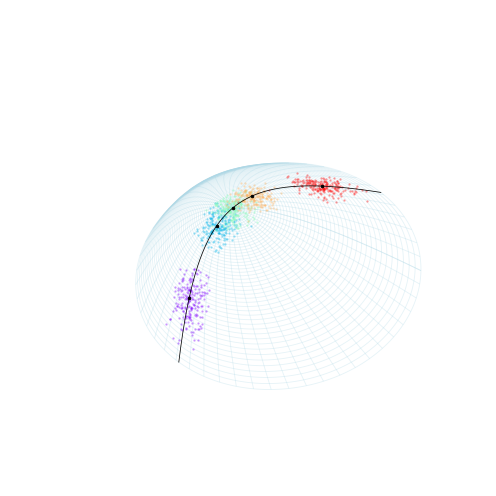

In [4]:
#For hyperboloid
u = np.linspace(0, .8, 1000)
v = np.linspace(0, 2*np.pi, 1000)

u, v = np.meshgrid(u, v)

x_grid = np.cosh(np.abs(u))
y_grid = np.sinh(np.abs(u)) * np.sign(u) * np.cos(v)
z_grid = np.sinh(np.abs(u)) * np.sign(u) * np.sin(v)

# Define the parameter theta
theta = np.linspace(-.8, .8, 10000)

# Generate 10 random unit vectors in R2
mu = np.array([1/np.sqrt(2), 1/np.sqrt(2)])  # Fixed unit vector in R^2

fig=plt.figure(constrained_layout=True)
fig.set_size_inches(7, 7)
ax = plt.axes(projection='3d', computed_zorder=False)
# ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
x_curve = np.cosh(np.abs(theta))
y_curve = np.sinh(np.abs(theta)) * np.sign(theta) * mu[0]
z_curve = np.sinh(np.abs(theta)) * np.sign(theta) * mu[1]
ax.plot_wireframe(x_grid, y_grid, z_grid, color='lightblue', alpha=0.3, zorder = 0, linewidth = 0.85)
# ax.plot_surface(x_grid, y_grid, z_grid, color='lightblue', alpha=0.3, zorder = 0)

ax.plot(x_curve, y_curve, z_curve, color='black', linewidth = 0.75, label=r'$\boldsymbol{m}_0(\theta)$', zorder = 1)

cmap = plt.cm.rainbow

# Centers
for i in range(5):
    color = cmap(i/4)
    if i == 0:
        p = 0.01
    elif i == 1:
        p = 0.25
    elif i == 2:
        p = 0.5
    elif i == 3:
        p = 0.75
    else:
        p = 0.99
    ax.plot(hyp_points['V1'][i*200:(i+1)*200], hyp_points['V2'][i*200:(i+1)*200], hyp_points['V3'][i*200:(i+1)*200], marker = '.', color = color, lw = 0, markersize = 3, label= f'$\\theta=\\frac{{1}}{{4}} \\Phi^{{-1}}({p})$', alpha = 0.25, zorder = 0)
  
ax.plot(np.cosh(0.5815870), np.sinh(0.5815870) * mu[0], np.sinh(0.5815870) * mu[1], color='black', marker = '.', lw = 0, markersize = 5, zorder = 1)
ax.plot(np.cosh(0.1686224), np.sinh(0.1686224) * mu[0], np.sinh(0.1686224) * mu[1], color='black', marker = '.', lw = 0, markersize = 5, zorder = 1)
ax.plot(np.cosh(0), np.sinh(0) * mu[0], np.sinh(0) * mu[1], color='black', marker = '.', lw = 0, markersize = 5, zorder = 1)
ax.plot(np.cosh(0.1686224), -np.sinh(0.1686224) * mu[0], -np.sinh(0.1686224) * mu[1], color='black', marker = '.', lw = 0, markersize = 5, zorder = 1)
ax.plot(np.cosh(0.5815870), -np.sinh(0.5815870) * mu[0], -np.sinh(0.5815870) * mu[1], color='black', marker = '.', lw = 0, markersize = 5, zorder = 1)
#ax.plot_wireframe(x_grid, y_grid, z_grid, color='lightblue', alpha=0.3, zorder = 0)

ax.set_axis_off()
#ax.set_xlim(0.9, 1.4)  # Zoom in on x-axis
ax.set_ylim(-1, 1)      # Only show positive y (0 to 1 instead of -1 to 1)
#ax.set_zlim(-.8, .8)  # Zoom in on z-axis
ax.view_init(elev=15, azim=-10, roll = 0)
ax.grid(False)

# Axes3D.set_aspect(ax, 'auto')
# fig.subplots_adjust(top=1, bottom=0, left=-1, right=1)
h, l = ax.get_legend_handles_labels()
fig.tight_layout()
#ax.legend(reorder(h, 3), [label for label in reorder(l, 3)], ncol=3, loc='upper right', fontsize=13 #, columnspacing=1)

# Uncomment for save
# fig.savefig(os.getcwd() + '/simulations_H2/dibujo/hyperboloid_curve_one.png', bbox_inches='tight', dpi = 200, format='png', transparent=True)
plt.show()

/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_96271/2801592976.py:62: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


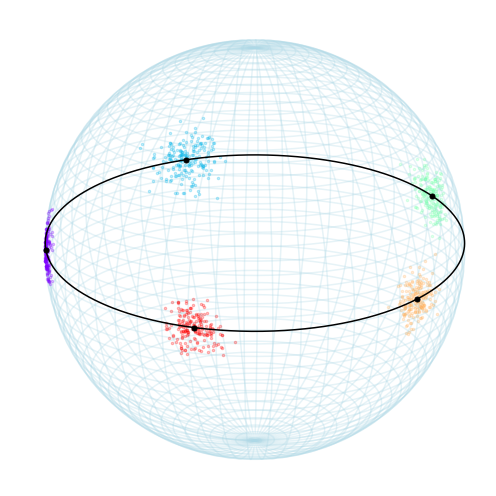

In [5]:
mu = np.array([1/np.sqrt(2), 1/np.sqrt(2)])  # Fixed unit vector in R^2

# Create directory for saving samples
save_folder = os.path.join(os.getcwd(), 'simulations_sphere', 'data')
os.makedirs(save_folder, exist_ok=True)

np.random.seed(1000)
sample_size = 1000
kappa = 200
theta_centers = np.array([0, 2*np.pi/5, 4*np.pi/5, 6*np.pi/5, 8*np.pi/5])  # Random angles
theta, Y = simulate_data(kappa, mu, theta_centers)
Y = Y.reshape(-1, 3)

theta_samples = np.linspace(0, 2*np.pi, 1000)

fig=plt.figure(constrained_layout=True)
fig.set_size_inches(7, 7)
ax = plt.axes(projection='3d', computed_zorder=False)

# Create a mesh grid for the unit sphere
u = np.linspace(0, np.pi, 100)
v = np.linspace(0, 2 * np.pi, 100)
u, v = np.meshgrid(u, v)

x_sphere = np.sin(u) * np.cos(v)
y_sphere = np.sin(u) * np.sin(v)
z_sphere = np.cos(u)

ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.3, zorder = 0)

curve = m_0(theta_samples, mu)

ax.plot(curve[:,0], curve[:,1], curve[:,2], color='black', label=r'$\boldsymbol{m}_0(\theta)$', zorder = 1)

# Plot the sphere surface

# Plot the von Mises-Fisher samples on the sphere
# add color rainbow palette so that the first each consecutive 200 points have the same color
cmap = plt.cm.rainbow
0, 2*np.pi/5, 4*np.pi/5, 6*np.pi/5, 8*np.pi/5
for i in range(5):
    color = cmap(i/4)
    if i == 0:
        p = f'$\\theta=0$'
    elif i == 1:
        p = f'$\\theta=\\frac{{2\pi}}{{5}}$'
    elif i == 2:
        p = f'$\\theta=\\frac{{4\pi}}{{5}}$'
    elif i == 3:
        p = f'$\\theta=\\frac{{6\pi}}{{5}}$'
    else:
        p = f'$\\theta=\\frac{{8\pi}}{{5}}$'
    color = cmap(i/4)
    ax.plot(Y[i*200:(i+1)*200, 0], Y[i*200:(i+1)*200, 1], Y[i*200:(i+1)*200, 2], marker = '.', color = color, lw = 0, markersize = 5, label = p, alpha = 0.25, zorder = 0)
    
# ax.plot(Y[:, 0], Y[:, 1], Y[:, 2], marker = '.', color='red', lw = 0, markersize = 5, label='Points on Hyperboloid', alpha = 0.25, zorder = 0)

ax.plot(np.cos(theta), np.sin(theta) * mu[0], np.sin(theta) * mu[1], color='black', marker = '.', lw = 0, markersize = 10, zorder = 1)

ax.grid(False)
ax.set_axis_off()
fig.tight_layout()
# Final plot settings - adjust view to better see the hemisphere with y > 0
ax.view_init(elev=20, azim=90)  # View from positive y-axis

ax.set_xlim(-0.3, .3)  # Zoom in on x-axis
ax.set_ylim(0, 1)      # Only show positive y (0 to 1 instead of -1 to 1)
ax.set_zlim(-.75, 1.2)  # Zoom in on z-axis
Axes3D.set_aspect(ax, 'equal')

# fig.subplots_adjust(top=1, bottom=0, left=-1, right=1)
h, l = ax.get_legend_handles_labels()
# ax.legend(reorder(h, 3), [label for label in reorder(l, 3)], ncol=3, loc='upper right', fontsize=13)
# Uncomment for save
# fig.savefig(os.getcwd() + '/simulations_H2/dibujo/sphere_curve_one.png', bbox_inches='tight', format='png', dpi = 75, transparent=True)
plt.show()

### SPD matrices

/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_96271/4143179369.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette=get_cmap('hsv')


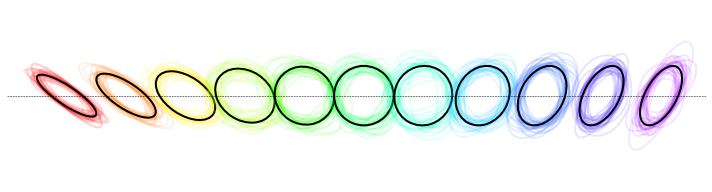

In [64]:
np.random.seed(1000)

# Define the matrices to interpolate
Sigma_1 = np.array([[1, -0.6],
                  [-0.6, 0.5]])
Sigma_2 = np.array([[1, 0],
                  [0, 1]])
Sigma_3 = np.array([[0.5, 0.4],
                  [0.4, 1]])

Sigmas = (Sigma_1, Sigma_2, Sigma_3)

q = 2
df = 15
c_dq = 2 * np.exp((1 / q) * sum( digamma((df - np.arange(1, q + 1) + 1 ) / 2) ))
sample = sim_regression_matrices(Sigmas = Sigmas, t = np.linspace(start=0, stop=1, num=11), df=df)
fig, ax=plt.subplots(figsize=(10,8))
color_palette=get_cmap('hsv')

for i in range(11):
    #plot_ellipse(predicted_curve[i], ax=ax, xy=(i/50,0), scale_factor=1/5,
    #             edgecolor=color_palette(i))
    true_Sigma = Sigma_t(t_array = np.array([sample['t'][i]]), Sigma_array=Sigmas)[0]

    for k in range(30):
        plot_ellipse(wishart(df=df, scale= 1/c_dq * true_Sigma).rvs(size=1), 
                     ax=ax, xy=(20*i/100, 0.5), scale_factor=1/5, edgecolor=color_palette(20*i), alpha=0.1)
        
    plot_ellipse(true_Sigma, ax=ax, xy=(20*i/100, 0.5), scale_factor=1/5,
        edgecolor='black')

            
ax.set_aspect('equal', 'box')
fig.set_size_inches(10, 6)
ax.set_xlim(-0.2 ,2.15)
ax.set_ylim(0.2,0.8)
ax.grid(False)
# plt.title('True curve (top row) and predicted (bottom row)')
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

fig.tight_layout()

# plt.axhline(y=0, linestyle='dashed', color='black', linewidth=0.5)
ax.axhline(y=0.5, linestyle='dashed', color='black', linewidth=0.5)
# Uncomment for save
fig.savefig(os.getcwd() + '/simulations_H2/SPD_interpolation_plot.png', bbox_inches='tight', format='png', transparent=True)
plt.show()

# Population prediction balls

## Sphere

/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_96271/185551270.py:105: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


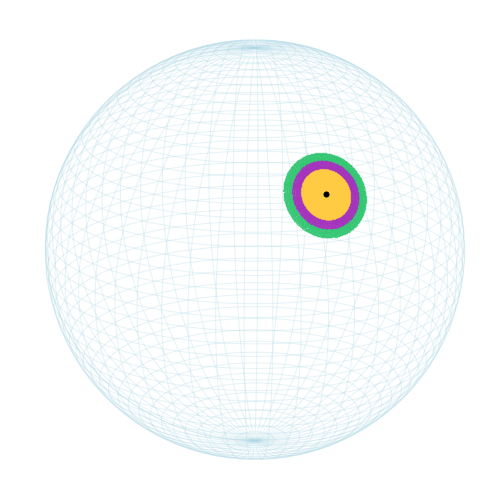

In [9]:
reorder = lambda l, nc: sum((l[i::nc] for i in range(nc)), [])
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
ax = plt.axes(projection='3d', computed_zorder=False)
fig.set_size_inches(7, 7)
# Setup
mu = np.array([0, 1])  # Fixed unit vector in R^2
alphas = [0.25, 0.1, 0.01]  # Alpha values
M = Sphere(dim=2)

np.random.seed(1000)
kappa = 200

# Calculate radii for different alpha values
R_alpha_values = []
theta_centers = np.array([np.pi/2])
for alpha in alphas:
    R_alpha = []
    for c in theta_centers:
        # Generate MC samples
        MC_samples = simulate_data(kappa, mu, np.array([c]))[1][0]
        cartesian_c = np.array([np.cos(c), np.sin(c) * mu[0], np.sin(c) * mu[1]])
        
        # Calculate distances
        sphere_distances = []
        for S in MC_samples:
            dist = M.d(S, cartesian_c)
            sphere_distances.append(dist)
        
        # Get quantile
        R_alpha.append(np.quantile(sphere_distances, 1 - alpha))
    R_alpha_values.append(R_alpha[0])

# Create points for the spherical caps
theta_max = np.pi / 15  # Cap angle
u_cap = np.linspace(0, theta_max, 75)  # polar angle (theta)
v_cap = np.linspace(0, 2 * np.pi, 250)  # azimuthal angle (phi)
u_cap, v_cap = np.meshgrid(u_cap, v_cap)

# Convert to Cartesian coordinates
x_cap = np.sin(u_cap) * np.cos(v_cap)
y_cap = np.sin(u_cap) * np.sin(v_cap)
z_cap = np.cos(u_cap)

# Create points array
Y = np.stack((x_cap, y_cap, z_cap), axis=-1).reshape(-1, 3)

# Plotting

# Plot the sphere
u = np.linspace(0, np.pi, 100)
v = np.linspace(0, 2 * np.pi, 100)
u, v = np.meshgrid(u, v)
x_sphere = np.sin(u) * np.cos(v)
y_sphere = np.sin(u) * np.sin(v)
z_sphere = np.cos(u)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.3, zorder=0, linewidth=1)

# Points for different regions
rotation_matrix = rotate_north_pole_to(np.array([-np.sqrt(0.1), np.sqrt(0.6), np.sqrt(.3)]))
cartesian_c = np.array([-np.sqrt(0.1), np.sqrt(0.6), np.sqrt(0.3)])  # Target point

# Plot the rotated spherical caps with different colors

for point in Y:
    rotated_point = rotation_matrix @ point
    dist = M.d(point, np.array([0, 0, 1]))  # Distance from north pole
    if dist < R_alpha_values[0]:  # alpha = 0.1 
        ax.scatter(1.0015*rotated_point[0], 1.0015*rotated_point[1], 1.0015*rotated_point[2], color='#FFCB42',
        s=0.15, alpha=1, zorder = 1)

for point in Y:
    rotated_point = rotation_matrix @ point
    dist = M.d(point, np.array([0, 0, 1]))  # Distance from north pole
    if dist < R_alpha_values[2] and dist >= R_alpha_values[1]:  # alpha = 0.01 
        ax.scatter(rotated_point[0], rotated_point[1], rotated_point[2], color='#33C773',
        s=0.15, alpha=1, zorder = 1)

for point in Y:
    rotated_point = rotation_matrix @ point
    dist = M.d(point, np.array([0, 0, 1]))  # Distance from north pole
    if dist < R_alpha_values[1] and dist >= R_alpha_values[0]:  # alpha = 0.05 
        ax.scatter(1.001*rotated_point[0], 1.001*rotated_point[1], 1.001*rotated_point[2], color='#A534BC',
        s=0.15, alpha=1, zorder = 1)
        
# Plot the center point
ax.scatter([-np.sqrt(0.1)], [np.sqrt(0.6)], [np.sqrt(0.3)], color='black', marker='.', s=100, zorder=1)

# Add a legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#33C773', markersize=8, label=r'$\alpha = 0.01$'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#A534BC', markersize=8, label=r'$\alpha = 0.05$'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFCB42', markersize=8, label=r'$\alpha = 0.1$')
]
# ax.legend(handles=legend_elements, loc='upper right', fontsize=13)

ax.view_init(elev=20, azim=90)  # View from positive y-axis

ax.set_xlim(-0.3, .3)  # Zoom in on x-axis
ax.set_ylim(0, 1)      # Only show positive y (0 to 1 instead of -1 to 1)
ax.set_zlim(-.75, 1.2)  # Zoom in on z-axis
Axes3D.set_aspect(ax, 'equal')
ax.grid(False)
ax.set_axis_off()

plt.tight_layout()
# Uncomment for save
# plt.savefig(os.path.join(os.getcwd(), 'prediction_balls_sphere.png'), bbox_inches='tight', format='png', dpi = 75, transparent=True)
plt.show()

/var/folders/z_/bb464vm54_vcx10blg24_d7m0000gn/T/ipykernel_96271/1947563265.py:148: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


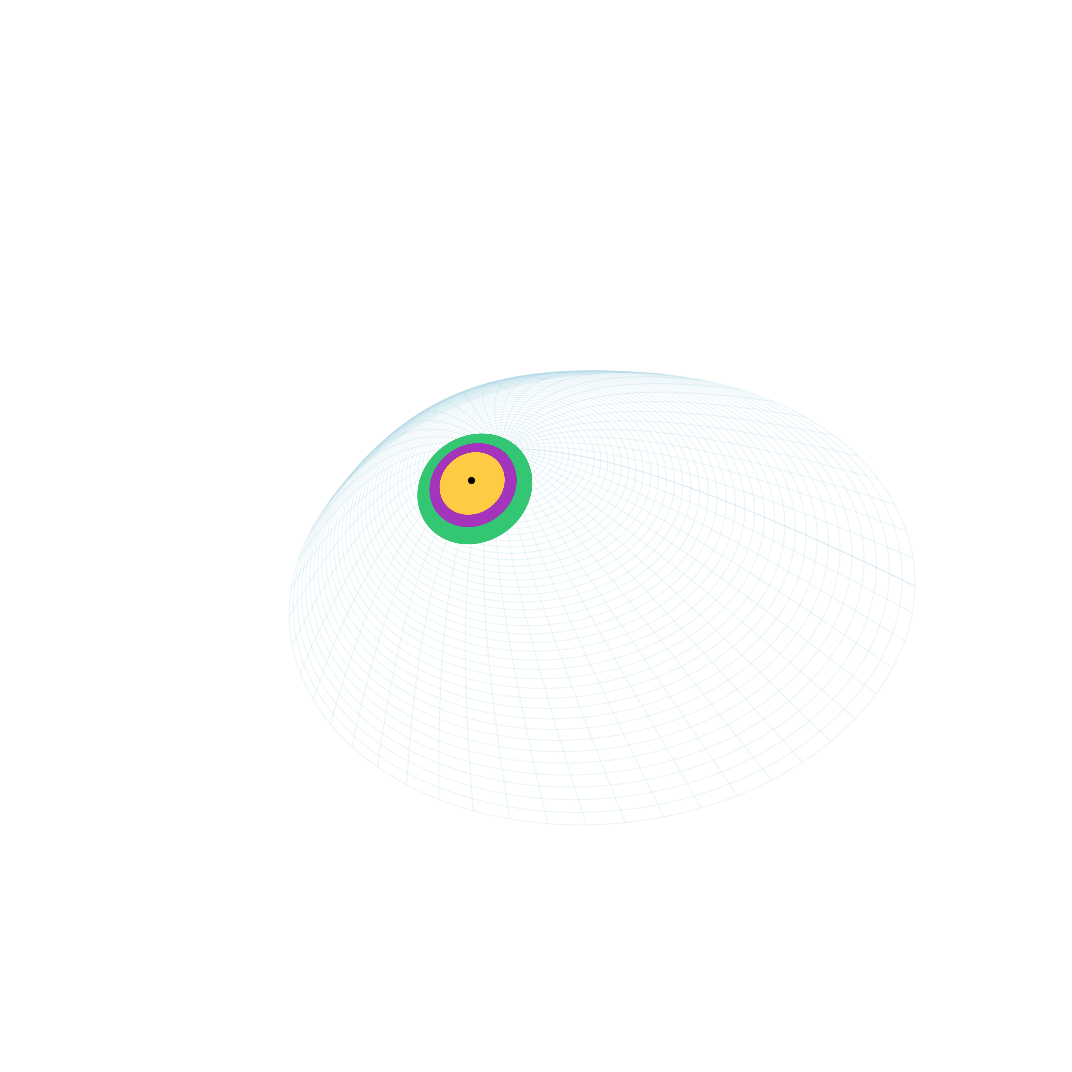

In [10]:
reorder = lambda l, nc: sum((l[i::nc] for i in range(nc)), [])
# Center point on the hyperboloid
mu = np.array([1/np.sqrt(2), 1/np.sqrt(2)])  # Fixed unit vector in R^2

alpha = np.array([0.25, 0.1, 0.01])  # Alpha values

center_t = -0.15 # Center for the prediction balls 
center_x = np.cosh(center_t)
center_y = np.sinh(center_t) * mu[0]
center_z = np.sinh(center_t) * mu[1]
center_point = np.array([center_x, center_y, center_z])

# Define the path to the CSV file
csv_path = '/Users/Diego/Desktop/Codigo/repo_edu_pyfrechet/pyfrechet/simulations_H2/dibujo/H2_dibujo_pball_repst.csv'
hyp_points = pd.read_csv(csv_path)
if 'Unnamed: 0' in hyp_points.columns:
    hyp_points.drop(columns=['Unnamed: 0'], inplace=True)
# Ensure columns are named correctly
if 'V1' not in hyp_points.columns:
    hyp_points.columns = ['t', 'V1', 'V2', 'V3']

M = H2(dim=2)
# Calculate distances
hyp_distances = []
for S in hyp_points.values[:,1:4]:
    dist = M.d(S, center_point)
    hyp_distances.append(dist)

# Get quantile
R_alpha = np.quantile(hyp_distances, 1 - alpha)
np.random.seed(1000)

# Create a finer grid around the center point for better visualization
t_range = 1  # Range around center to consider
t_min = max(0, center_t - t_range)
t_max = min(1, center_t + t_range)

# Create dense grid covering the hyperboloid surface
t_dense = np.linspace(t_min, t_max, 1000)
phi_dense = np.linspace(0, 2*np.pi, 2000)
t_grid, phi_grid = np.meshgrid(t_dense, phi_dense)

# Convert to Cartesian coordinates on the hyperboloid
x_points = np.cosh(t_grid)
y_points = np.sinh(t_grid) * np.cos(phi_grid)
z_points = np.sinh(t_grid) * np.sin(phi_grid)
points = np.stack((x_points.flatten(), y_points.flatten(), z_points.flatten()), axis=1)

# Calculate distances from each point to the center
distances = np.zeros(len(points))
for i, point in enumerate(points):
    distances[i] = M.d(point, center_point)

# For visualization, reshape distances back to grid shape
distances = distances.reshape(x_points.shape)

#For hyperboloid
u = np.linspace(0, .8, 1000)
v = np.linspace(0, 2*np.pi, 1000)

u, v = np.meshgrid(u, v)

x_grid = np.cosh(np.abs(u))
y_grid = np.sinh(np.abs(u)) * np.sign(u) * np.cos(v)
z_grid = np.sinh(np.abs(u)) * np.sign(u) * np.sin(v)

# Define the parameter theta
theta = np.linspace(-.8, .8, 10000)

# Generate 10 random unit vectors in R2
mu = np.array([1/np.sqrt(2), 1/np.sqrt(2)])  # Fixed unit vector in R^2

fig=plt.figure(constrained_layout=True)
fig.set_size_inches(15, 15)
ax = plt.axes(projection='3d', computed_zorder=False)
# ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
x_curve = np.cosh(np.abs(theta))
y_curve = np.sinh(np.abs(theta)) * np.sign(theta) * mu[0]
z_curve = np.sinh(np.abs(theta)) * np.sign(theta) * mu[1]
ax.plot_wireframe(x_grid, y_grid, z_grid, color='lightblue', alpha=0.3, zorder = 0, linewidth = 0.85)

# Plot points with colors based on their distances (prediction balls)
for alpha_idx, alpha in enumerate(alphas):
    radius = R_alpha[alpha_idx]
    mask = None
    
    if alpha_idx == 0:  # α = 0.1 (smallest radius, innermost ball)
        mask = (distances < radius)
        color = '#FFCB42'  # Yellow
        x_sel = x_points[mask]
        y_sel = y_points[mask]
        z_sel = z_points[mask]
    
    if mask is not None:
        # Use a smaller point size for dense plotting
        ax.scatter(x_sel, y_sel, z_sel, color=color, s=0.15, alpha=1, zorder=1)


for alpha_idx, alpha in enumerate(alphas):
    radius = R_alpha[alpha_idx]
    mask = None
    
    if alpha_idx == 2:
        mask = (distances >= R_alpha[1]) & (distances < radius)
        color = '#33C773'  # Green
        x_sel = 1.0015*x_points[mask]
        y_sel = 1.0015*y_points[mask]
        z_sel = 1.0015*z_points[mask]
    
    if mask is not None:
        # Use a smaller point size for dense plotting
        ax.scatter(x_sel, y_sel, z_sel, color=color, s=0.15, alpha=1, zorder=1)


for alpha_idx, alpha in enumerate(alphas):
    radius = R_alpha[alpha_idx]
    mask = None

    if alpha_idx==1:   # α = 0.05 (middle radius)
        mask = (distances >= R_alpha[0]) & (distances < radius)
        color = '#A534BC'  # Purple
        x_sel = 1.001*x_points[mask]
        y_sel = 1.001*y_points[mask]
        z_sel = 1.001*z_points[mask]
    
    if mask is not None:
        # Use a smaller point size for dense plotting
        ax.scatter(x_sel, y_sel, z_sel, color=color, s=0.15, alpha=1, zorder=1)

ax.scatter(center_x, center_y, center_z, color='black', marker='.', s=150, zorder=1)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#33C773', markersize=8, label=r'$\alpha = 0.01$'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#A534BC', markersize=8, label=r'$\alpha = 0.05$'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFCB42', markersize=8, label=r'$\alpha = 0.1$')
]

ax.set_axis_off()
#ax.set_xlim(0.9, 1.4)  # Zoom in on x-axis
ax.set_ylim(-1, 1)      # Only show positive y (0 to 1 instead of -1 to 1)
#ax.set_zlim(-.8, .8)  # Zoom in on z-axis
ax.view_init(elev=15, azim=-10, roll = 0)
ax.grid(False)

# Axes3D.set_aspect(ax, 'auto')
# fig.subplots_adjust(top=1, bottom=0, left=-1, right=1)
h, l = ax.get_legend_handles_labels()
fig.tight_layout()

plt.tight_layout()
# Uncomment for save
# plt.savefig(os.path.join(os.getcwd(), 'prediction_balls_hyperboloid.png'), bbox_inches='tight', dpi = 75, format='png', transparent=True)
plt.show()